In [1]:
import pandas as pd

# 날짜 컬럼 방지
def read_csv_auto_dates(path):
    # 1) 전체 파일을 먼저 읽기
    temp = pd.read_csv(path, low_memory=False)
    
    # 2) _at 로 끝나는 컬럼 자동 탐지
    date_cols = [col for col in temp.columns if col.endswith('_at')]
    
    # 3) 다시 날짜 컬럼을 datetime 으로 읽기
    return pd.read_csv(path, parse_dates=date_cols, low_memory=False)

# Load Files (전처리)
acq = read_csv_auto_dates("./clean_data_v1/clean_acquisitions_final.csv")
deg = read_csv_auto_dates("./clean_data_v1/clean_degrees_final.csv")
frs = read_csv_auto_dates("./clean_data_v1/clean_fr_final.csv")
fds = read_csv_auto_dates("./clean_data_v1/clean_funds_final.csv")
inv = read_csv_auto_dates("./clean_data_v1/clean_investments_final.csv")
ipo = read_csv_auto_dates("./clean_data_v1/clean_ipos_final.csv")
mil = read_csv_auto_dates("./clean_data_v1/clean_milestones_final.csv")
obj = read_csv_auto_dates("./clean_data_v1/clean_objects_final.csv")
peo = read_csv_auto_dates("./clean_data_v1/clean_people_final.csv")
off = read_csv_auto_dates("./clean_data_v1/clean_offices_final.csv")
rel = read_csv_auto_dates("./clean_data_v1/clean_relationships_final.csv")

# Load Files (작업용 전처리)
company = read_csv_auto_dates("./entity_type/objects_company.csv")
finorg = read_csv_auto_dates("./entity_type/objects_finorg.csv")
person = read_csv_auto_dates("./entity_type/objects_person.csv")
product = read_csv_auto_dates("./entity_type/objects_product.csv")

# statistic join load
startup_profile = read_csv_auto_dates("./statistic_join/cy_startup_profile.csv")
founder_master = read_csv_auto_dates("./statistic_join/founder_master.csv")

print("="*60)
print("Dataset 로드 완료!")
print("="*60)

Dataset 로드 완료!


## 생존분석
언제 투자하는가 ?

어떤 요인이 투자를 앞당기거나 늦추는가 ?

### 시간 정의
- START :  object 테이블의 founded_at

    = 회사가 “투자 대상”으로 시장에 등장한 시점

- END (이벤트 발생 시점): object 테이블의 first_funding_at

    = 첫 VC 투자가 실제로 발생한 시점

- 이벤트 정의

    - event = 1 → 첫 VC 투자 발생

    - event = 0 → 데이터 종료 시점까지 투자 안 받음 (검열)

In [2]:
# object 테이블에서 회사만 거르기 
objects_surv = obj.copy()

# 회사(c:)만 남기기
objects_surv = objects_surv[
    objects_surv['objects_cfpr_id'].str.startswith('c:', na=False)
].copy()

# event 발생 컬럼 생성
objects_surv['event'] = objects_surv['first_funding_at'].notna().astype(int)


# duration 컬럼 생성
analysis_end = objects_surv['first_funding_at'].max()

objects_surv['end_date'] = objects_surv['first_funding_at'].fillna(analysis_end)

objects_surv['duration_months'] = (
    ((objects_surv['end_date'] - objects_surv['founded_at']).dt.days / 30.44)
    .round()
    .astype('Int64')
)


# 이상치 제거
objects_surv = objects_surv[
    (objects_surv['duration_months'].notna()) &
    (objects_surv['duration_months'] > 0)
]

objects_surv

,objects_cfpr_id,entity_type,parent_c_id,normalized_name,category_code,status,founded_at,closed_at,description,overview,...,obj_region_fixed,cat_obj_region,obj_state_filled,obj_city_fixed,obj_category_filled,is_obj_funding_total_usd_private,is_obj_funding_rounds_private,event,end_date,duration_months
3,c:10000,Company,NaN,mywebbo,network_hosting,operating,2008-07-26,NaT,NaN,"BRAND NEW ONLINE SOCIAL NETWORKING WEBSITE,FOR...",...,NaN,NaN,NaN,NaN,network_hosting,0,0,0,2013-12-12,65
4,c:10001,Company,NaN,the movie streamer,games_video,operating,2008-07-26,NaT,NaN,This company shows free movies online on their...,...,NaN,NaN,NaN,NaN,games_video,0,0,0,2013-12-12,65
5,c:10002,Company,NaN,synergie media,advertising,operating,2007-06-27,NaT,NaN,Synergie Media is a Dutch and Moroccan Web Des...,...,agadir,agadir,NaN,agadir,advertising,0,0,0,2013-12-12,78
6,c:10003,Company,NaN,green basti ecosystems,cleantech,operating,2008-08-20,NaT,NaN,Creating infrastructure to provide incentives ...,...,vadodara,vadodara,NaN,vadodara,cleantech,0,0,0,2013-12-12,64
9,c:100062,Company,NaN,vetter idea management system,enterprise,operating,2011-08-01,NaT,SaaS Idea Management System,Vetter is a web-based system that helps manage...,...,NaN,NaN,NaN,NaN,enterprise,0,0,0,2013-12-12,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196544,c:99940,Company,NaN,webgility,ecommerce,operating,2007-01-01,NaT,eCommerce automation & integration,Webgility is the leading provider in QuickBook...,...,sf bay area,sf bay area,CA,san francisco,ecommerce,0,0,0,2013-12-12,83
196545,c:9995,Company,NaN,fohboh,public_relations,operating,2007-11-01,NaT,Foodservice industry social-busi network,"Online B2B Community - Food, Tech & Media\nWit...",...,sf bay area,sf bay area,CA,san jose,public_relations,0,0,1,2008-08-25,10
196546,c:9996,Company,NaN,csc,consulting,operating,1959-01-01,NaT,IT services,CSC is a leading global IT services company. C...,...,washington dc,washington dc,VA,falls church,consulting,0,0,0,2013-12-12,659
196547,c:9997,Company,NaN,top candidate,search,operating,2008-07-01,NaT,NaN,Top-candidate is a premium database of high q...,...,los angeles,los angeles,CA,los angeles,search,0,0,0,2013-12-12,65


In [3]:
# 설명 변수 선정

cov_cols_object = [
    'obj_category_filled',          # 산업
    'obj_city_fixed',         # 지역
]

objects_surv = objects_surv.merge(
    obj[cov_cols_object + ['objects_cfpr_id']],
    on='objects_cfpr_id',
    how='left'
)


In [4]:
founder_master

,rel_p_id,rel_cf_id,n_founding,is_past,sequence,birthplace,degree_level,subject,institution,graduated_at
0,p:10,c:5,1,0,1,NaN,NaN,Computer Science / Software,harvard university,NaN
1,p:100009,c:152329,2,0,1,NaN,NaN,NaN,NaN,NaN
2,p:100009,c:81559,2,0,2,NaN,NaN,NaN,NaN,NaN
3,p:100017,c:81564,1,0,1,NaN,NaN,NaN,NaN,NaN
4,p:100025,c:287,1,0,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
59961,p:99982,c:16993,2,1,1,NaN,NaN,NaN,NaN,NaN
59962,p:99982,c:81541,2,0,2,NaN,NaN,NaN,NaN,NaN
59963,p:99988,c:64683,1,0,1,NaN,2.0,Computer Science / Software,bristol university,2004-01-01
59964,p:99994,c:3643,1,0,1,NaN,2.0,Marketing / Communications,"madras, india university",NaN


In [5]:
# founder_master 테이블에서 필요한 컬럼 선택

founder_cols = [
    'rel_cf_id',        # 회사 ID
    'rel_p_id',         # 창업자 ID
    'degree_level',
    'subject',
    'institution',
    'birthplace'
]

founder_use = founder_master[founder_cols].copy()

# c: 기준 한 행으로 만들기 위한 집계
# degree_level 내림차순으로 정렬
founder_sorted = (
    founder_use
    .sort_values(
        by=['rel_cf_id', 'degree_level'],
        ascending=[True, False]
    )
)

# 회사별 1명만 선택 (최고 학위)
founder_company_rep = (
    founder_sorted
    .drop_duplicates(subset='rel_cf_id', keep='first')
    .reset_index(drop=True)
)


In [6]:
# objects_surv와 조인
objects_surv = objects_surv.merge(
    founder_company_rep[
        [
            'rel_cf_id',
            'degree_level',
            'subject',
            'institution',
            'birthplace'
        ]
    ],
    left_on='objects_cfpr_id',
    right_on='rel_cf_id',
    how='left'
).drop(columns=['rel_cf_id'])

# 형 변환

objects_surv['degree_level'] = (
    pd.to_numeric(objects_surv['degree_level'], errors='coerce')
)

objects_surv['duration_months'] = (
    pd.to_numeric(objects_surv['duration_months'], errors='coerce')
)

objects_surv['degree_level'] = objects_surv['degree_level'].fillna(0).astype('Int64')
objects_surv['duration_months'] = objects_surv['duration_months'].fillna(0).astype('Int64')

In [8]:
objects_surv

,objects_cfpr_id,entity_type,parent_c_id,normalized_name,category_code,status,founded_at,closed_at,description,overview,...,is_obj_funding_rounds_private,event,end_date,duration_months,obj_category_filled_y,obj_city_fixed_y,degree_level,subject,institution,birthplace
0,c:10000,Company,NaN,mywebbo,network_hosting,operating,2008-07-26,NaT,NaN,"BRAND NEW ONLINE SOCIAL NETWORKING WEBSITE,FOR...",...,0,0,2013-12-12,65,network_hosting,NaN,0,NaN,NaN,NaN
1,c:10001,Company,NaN,the movie streamer,games_video,operating,2008-07-26,NaT,NaN,This company shows free movies online on their...,...,0,0,2013-12-12,65,games_video,NaN,0,NaN,NaN,NaN
2,c:10002,Company,NaN,synergie media,advertising,operating,2007-06-27,NaT,NaN,Synergie Media is a Dutch and Moroccan Web Des...,...,0,0,2013-12-12,78,advertising,agadir,3,Computer Science / Software,NaN,NaN
3,c:10003,Company,NaN,green basti ecosystems,cleantech,operating,2008-08-20,NaT,NaN,Creating infrastructure to provide incentives ...,...,0,0,2013-12-12,64,cleantech,vadodara,0,NaN,NaN,NaN
4,c:100062,Company,NaN,vetter idea management system,enterprise,operating,2011-08-01,NaT,SaaS Idea Management System,Vetter is a web-based system that helps manage...,...,0,0,2013-12-12,28,enterprise,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87609,c:99940,Company,NaN,webgility,ecommerce,operating,2007-01-01,NaT,eCommerce automation & integration,Webgility is the leading provider in QuickBook...,...,0,0,2013-12-12,83,ecommerce,san francisco,0,NaN,NaN,NaN
87610,c:9995,Company,NaN,fohboh,public_relations,operating,2007-11-01,NaT,Foodservice industry social-busi network,"Online B2B Community - Food, Tech & Media\nWit...",...,0,1,2008-08-25,10,public_relations,san jose,0,NaN,NaN,NaN
87611,c:9996,Company,NaN,csc,consulting,operating,1959-01-01,NaT,IT services,CSC is a leading global IT services company. C...,...,0,0,2013-12-12,659,consulting,falls church,0,NaN,NaN,NaN
87612,c:9997,Company,NaN,top candidate,search,operating,2008-07-01,NaT,NaN,Top-candidate is a premium database of high q...,...,0,0,2013-12-12,65,search,los angeles,0,NaN,NaN,NaN


In [9]:
# 생존 분석에 활용할 컬럼
survival_df = objects_surv[
    [
        'objects_cfpr_id',
        'duration_months',
        'event',
        'obj_category_filled_x',
        'obj_city_fixed_x',
        'degree_level',
        'subject', 
        'institution',
        'birthplace'
        
    ]
].copy()

In [10]:
survival_df

,objects_cfpr_id,duration_months,event,obj_category_filled_x,obj_city_fixed_x,degree_level,subject,institution,birthplace
0,c:10000,65,0,network_hosting,NaN,0,NaN,NaN,NaN
1,c:10001,65,0,games_video,NaN,0,NaN,NaN,NaN
2,c:10002,78,0,advertising,agadir,3,Computer Science / Software,NaN,NaN
3,c:10003,64,0,cleantech,vadodara,0,NaN,NaN,NaN
4,c:100062,28,0,enterprise,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
87609,c:99940,83,0,ecommerce,san francisco,0,NaN,NaN,NaN
87610,c:9995,10,1,public_relations,san jose,0,NaN,NaN,NaN
87611,c:9996,659,0,consulting,falls church,0,NaN,NaN,NaN
87612,c:9997,65,0,search,los angeles,0,NaN,NaN,NaN


## Step 1. Kaplan–Meier (KM) 곡선

“투자받을 확률이 시간에 따라 어떻게 떨어지는지”

설명용

그림 1장으로 스토리 완성

## Step 2. Log-rank test

집단 간 차이가 통계적으로 다른지

## Step 3. Cox 비례위험 모형 (핵심)

“어떤 요인이 투자를 앞당기는가 / 늦추는가”

In [11]:
# ! pip3 install lifelines

In [14]:
# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta


# 한글 안깨지게 맥북용
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 8)

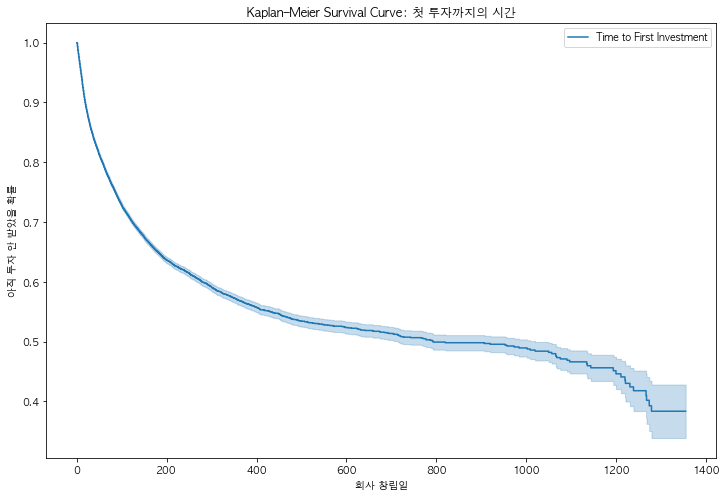

In [15]:
# Kaplan–Meier 곡선
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()

kmf.fit(
    durations=survival_df['duration_months'],
    event_observed=survival_df['event'],
    label='Time to First Investment'
)

kmf.plot()
plt.xlabel('회사 창립일')
plt.ylabel('아직 투자 안 받았을 확률')
plt.title('Kaplan–Meier Survival Curve: 첫 투자까지의 시간')
plt.show()


시간이 지날수록 미투자 상태에 남아 있을 확률은 점진적으로 감소한다.

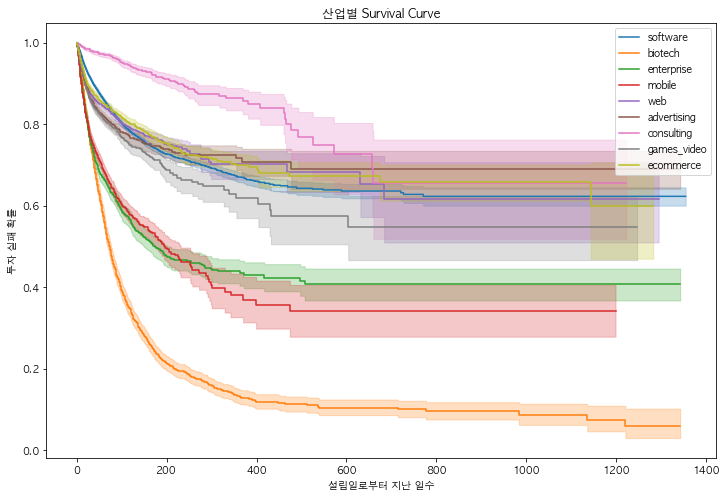

In [38]:
# 산업별로 비교 
fig, ax = plt.subplots()

for cat in ['software', 'biotech', 'enterprise', 'mobile', 'web', 'advertising', 'consulting', 'games_video', 'ecommerce']:
    mask = survival_df['obj_category_filled_x'] == cat
    if mask.sum() < 50:
        continue
        
    kmf.fit(
        survival_df.loc[mask, 'duration_months'],
        survival_df.loc[mask, 'event'],
        label=cat
    )
    kmf.plot(ax=ax)

plt.title('산업별 Survival Curve')
plt.xlabel('설립일로부터 지난 일수')
plt.ylabel('투자 실패 확률')
plt.show()


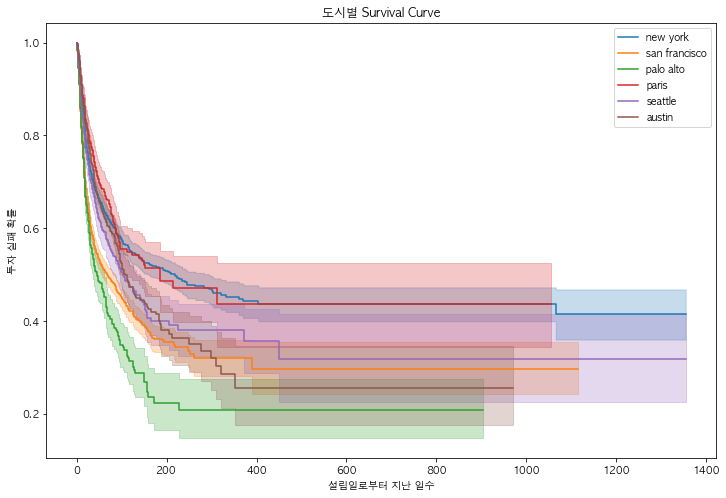

In [21]:
# 도시별로 비교 
fig, ax = plt.subplots()

for cat in ['new york', 'san francisco', 'palo alto', 'paris', 'seattle', 'austin']:
    mask = survival_df['obj_city_fixed_x'] == cat
    if mask.sum() < 50:
        continue
        
    kmf.fit(
        survival_df.loc[mask, 'duration_months'],
        survival_df.loc[mask, 'event'],
        label=cat
    )
    kmf.plot(ax=ax)

plt.title('도시별 Survival Curve')
plt.xlabel('설립일로부터 지난 일수')
plt.ylabel('투자 실패 확률')
plt.show()


In [36]:
# 범주형 변수 
dum_cols = [
    'duration_months',
    'event',
    'obj_category_filled_x',
    'obj_city_fixed_x',
    'degree_level',
    'subject', 
    'institution',
    'birthplace'
]
df= survival_df[dum_cols].copy()

# 상위 N개만 더미로 줄이기 (birthplace, institution)
def process_top_n(s, n=10, other="Other", missing="Missing"):
    # 1. 결측치 처리 및 상위 n개 추출
    s = s.fillna(missing)
    top_n_idx = s[s != missing].value_counts().head(n).index
    
    # 2. Top-n 및 Missing 외에는 Other로 변경
    s = s.where(s.isin(top_n_idx) | (s == missing), other)
    
    # 3. Categorical 변환 (Other를 가장 먼저 배치하여 drop_first 시 기준이 되게 함)
    # 실제 존재하는 값들 중 Other와 Missing을 제외한 나머지 정렬
    remains = sorted([x for x in s.unique() if x not in [other, missing]])
    categories = [other, missing] + remains
    
    return pd.Categorical(s, categories=categories, ordered=True)

###########################################################################################
# 상위 N개만 더미로 줄이기 (subject)
def process_top_n_subject(s, n=10, other_existing="Others / Unknown", missing="Missing"):
    s = s.fillna(missing)

    # Top-N은 Missing/기존기타 제외하고 계산
    top_n_idx = s[~s.isin([missing, other_existing])].value_counts().head(n).index

    # Top-N / Missing / 기존기타 외에는 전부 기존기타로
    s = s.where(s.isin(top_n_idx) | s.isin([missing, other_existing]), other_existing)

    # drop_first=True에서 "첫 번째 카테고리"가 기준이 되므로 기존기타를 맨 앞에 둠
    remains = sorted([x for x in s.unique() if x not in [other_existing, missing]])
    categories = [other_existing, missing] + remains
    return pd.Categorical(s, categories=categories, ordered=True)

# --- 적용 ---
df2 = survival_df[dum_cols].copy()

for col in ['obj_category_filled_x', 'obj_city_fixed_x', 'birthplace', 'institution']:
    df2[col] = process_top_n(df2[col], n=10)

# subject만 예외 처리 (기존 기타를 기준으로)
df2['subject'] = process_top_n_subject(df2['subject'], n=10, other_existing="Others / Unknown", missing="Missing")

# get_dummies 실행 (drop_first=True로 인해 각 컬럼의 첫 번째 카테고리인 'Other'가 자동 제거됨)
df_model_lo = pd.get_dummies(df2, columns=['birthplace', 'subject', 'institution', 'obj_category_filled_x',
                                           'obj_city_fixed_x'], drop_first=True)

# 전부 숫자형으로 강제 
df_model_lo = df_model_lo.astype(float)

In [37]:
# Cox 비례위험 모형: 언제 받았는가 ?

from lifelines import CoxPHFitter

cph = CoxPHFitter()

cph.fit(
    df_model_lo,
    duration_col='duration_months',
    event_col='event'
)

cph.print_summary()


<lifelines.CoxPHFitter: fitted with 87614 total observations, 66880 right-censored observations>
             duration col = 'duration_months'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 87614
number of events observed = 20734
   partial log-likelihood = -215552.33
         time fit was run = 2025-12-20 05:26:57 UTC

---
                                                         coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                
degree_level                                             0.07      1.07      0.01            0.04            0.10                1.04                1.10
birthplace_Missing                                       0.11      1.12      0.06            0.00            0.23                1.00                1.25
birthplace_Argentina                                     0.70      2.02      0.27            0.17            1.24                1.18                3.45
birthplace_Brazil                                        0.68      1.98      0.26            0.18            1.18                1.20                3.27
birthplace_Canada                                        0.08      1.08      0.17           -0.26            0.42                0.77                1.52
birthplace_China                                        -0.02      0.98      0.29           -0.59            0.56                0.55                1.75
birthplace_France                                       -0.04      0.96      0.20           -0.43            0.35                0.65                1.42
birthplace_Germany                                      -0.49      0.61      0.26           -1.00            0.01                0.37                1.01
birthplace_India                                         0.05      1.05      0.15           -0.25            0.34                0.78                1.41
birthplace_Israel                                        0.81      2.26      0.21            0.40            1.23                1.49                3.42
birthplace_United Kingdom                                0.21      1.24      0.12           -0.03            0.45                0.97                1.57
birthplace_United States                                 0.15      1.16      0.07            0.01            0.29                1.01                1.34
subject_Missing                                          0.05      1.05      0.08           -0.11            0.21                0.89                1.23
subject_Arts / Humanities                                0.15      1.17      0.12           -0.09            0.40                0.91                1.49
subject_Business Administration                          0.18      1.20      0.10           -0.02            0.38                0.98                1.46
subject_Computer Science / Software                      0.15      1.16      0.08           -0.01            0.30                0.99                1.35
subject_Design / Architecture                            0.23      1.26      0.25           -0.27            0.73                0.76                2.07
subject_Finance / Accounting                             0.13      1.14      0.10           -0.06            0.32                0.94                1.38
subject_Law                                              0.18      1.20      0.13           -0.07            0.42                0.94                1.53
subject_Marketing / Communications                       0.20      1.22      0.09            0.02            0.37                1.02                1.45
subject_Medicine / Clinical Science                      0.13      1.14      0.19           -0.24            0.49                0.79                1.64
subject_Physics / Chemistry                              0.03      1.03      0.